Data Loaded: 7032 rows, 20 columns

Training Model...

--- Model Performance (Test Set) ---
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.79      0.60       374

    accuracy                           0.72      1407
   macro avg       0.69      0.74      0.69      1407
weighted avg       0.79      0.72      0.74      1407

ROC-AUC Score: 0.8343


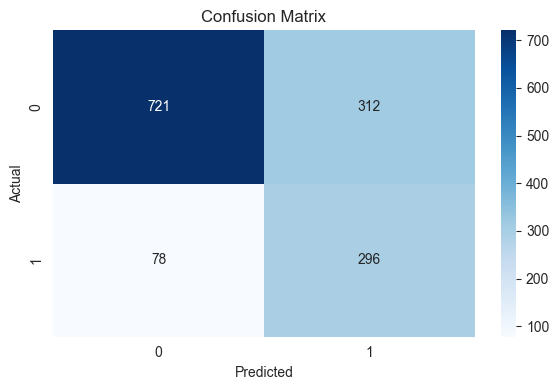

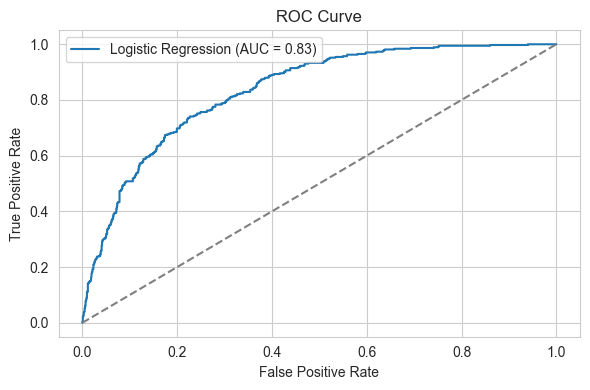


--- Top 3 Factors Driving Churn (Risk) ---
                    Feature  Coefficient
InternetService_Fiber optic     0.940817
    Contract_Month-to-month     0.763800
      tenure_group_4+ Years     0.343149

--- Top 3 Factors Driving Retention (Safety) ---
           Feature  Coefficient
 Contract_Two year    -0.838393
InternetService_No    -1.024844
            tenure    -1.090035

--- Business Summary ---
Total Customers in Test: 1407
High Risk Customers identified (>60% prob): 493
Strategy: Target these specific high-risk customers with a '12-Month Contract Discount' offer.

[SUCCESS] High-risk customer list exported to 'high_risk_customers.csv'.
Ready to be sent to the Retention Marketing Team.


In [2]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Sklearn Imports
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Configuration
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")
FILENAME = "WA_Fn-UseC_-Telco-Customer-Churn.csv"

# =========================================================
# 1. LOAD & CLEAN DATA
# =========================================================

try:
    df = pd.read_csv(FILENAME)
except FileNotFoundError:
    print(f"Error: '{FILENAME}' not found. Please check the file path.")
    exit()

# Standardize column names
df.columns = df.columns.str.strip()

# CRITICAL: Drop unique identifier to prevent overfitting
if "customerID" in df.columns:
    df.drop("customerID", axis=1, inplace=True)

# Standardize Target (Yes/No -> 1/0)
if "Churn" in df.columns:
    df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

# Fix 'TotalCharges' (Coerce blank strings to NaN, then fill or drop)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df.dropna(inplace=True)  # Drop rows with missing TotalCharges (usually < 0.2% of data)

# Simplify categorical values (e.g., "No internet service" -> "No")
replace_cols = [ "OnlineSecurity", "OnlineBackup", "DeviceProtection", 
                 "TechSupport", "StreamingTV", "StreamingMovies" ]
for col in replace_cols:
    if col in df.columns:
        df[col] = df[col].replace({"No internet service": "No"})

if "MultipleLines" in df.columns:
    df["MultipleLines"] = df["MultipleLines"].replace({"No phone service": "No"})

print(f"Data Loaded: {df.shape[0]} rows, {df.shape[1]} columns")

# =========================================================
# 2. FEATURE ENGINEERING
# =========================================================

# Create 'tenure_group' to simplify analysis
if "tenure" in df.columns:
    df["tenure_group"] = pd.cut(df["tenure"], 
                                bins=[-1, 12, 24, 48, 72], 
                                labels=["0-1 Year", "1-2 Years", "2-4 Years", "4+ Years"])

# Define Features (X) and Target (y)
X = df.drop("Churn", axis=1)
y = df["Churn"]

# =========================================================
# 3. SPLIT & PREPROCESS
# =========================================================

# Stratified Split: Keeps the Churn rate consistent in Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Identify column types automatically
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

# Define Transformers
# Note: sparse_output=False returns dense arrays, easier for feature importance extraction later
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ]
)

# =========================================================
# 4. MODEL PIPELINE
# =========================================================

# Logistic Regression with class_weight='balanced' handles the imbalance (fewer churners than stayers)
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear"))
])

# =========================================================
# 5. TRAINING & EVALUATION
# =========================================================

print("\nTraining Model...")
model.fit(X_train, y_train)

# Generate Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Metrics
roc_score = roc_auc_score(y_test, y_proba)
print("\n--- Model Performance (Test Set) ---")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_score:.4f}")

# =========================================================
# 6. VISUALIZATION
# =========================================================

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_score:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

# =========================================================
# 7. FEATURE IMPORTANCE
# =========================================================

try:
    # Extract feature names
    cat_names = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_cols)
    feature_names = np.r_[num_cols, cat_names]
    
    # Extract coefficients
    coeffs = model.named_steps['classifier'].coef_[0]
    
    # Create DataFrame
    importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coeffs})
    importance = importance.sort_values(by='Coefficient', ascending=False)
    
    print("\n--- Top 3 Factors Driving Churn (Risk) ---")
    print(importance.head(3).to_string(index=False))
    
    print("\n--- Top 3 Factors Driving Retention (Safety) ---")
    print(importance.tail(3).to_string(index=False))

except Exception as e:
    print(f"Could not extract feature importance: {e}")

# =========================================================
# 8. ACTIONABLE STRATEGY
# =========================================================

# Identify high-risk customers (Threshold > 60%)
risk_threshold = 0.60
high_risk_count = (y_proba >= risk_threshold).sum()

print(f"\n--- Business Summary ---")
print(f"Total Customers in Test: {len(X_test)}")
print(f"High Risk Customers identified (>60% prob): {high_risk_count}")
print("Strategy: Target these specific high-risk customers with a '12-Month Contract Discount' offer.")

# =========================================================
# 9. EXPORT FOR MARKETING TEAM
# =========================================================

# Filter the original test data for the high-risk customers
high_risk_df = X_test[y_proba >= risk_threshold].copy()

# Add the probability score so they know WHO to prioritize
high_risk_df['Churn_Probability'] = y_proba[y_proba >= risk_threshold]

# Sort by highest risk first
high_risk_df = high_risk_df.sort_values(by='Churn_Probability', ascending=False)

# Select key columns for the report (e.g., tenure, contract type)
report_cols = ['tenure_group', 'Contract', 'MonthlyCharges', 'Churn_Probability']
# Note: Add 'tenure_group' if it exists, otherwise remove it from this list
if 'tenure_group' not in high_risk_df.columns:
    report_cols.remove('tenure_group')

# Export
filename = "high_risk_customers.csv"
high_risk_df.to_csv(filename, columns=report_cols + list(high_risk_df.columns.difference(report_cols)))
print(f"\n[SUCCESS] High-risk customer list exported to '{filename}'.")
print("Ready to be sent to the Retention Marketing Team.")